In [ ]:
# Install the required libraries
!pip install prophet

In [4]:
# Dependencies
# NOTE: We might not use all of these. I just improrted everything I can think of for now. We'll delete the ones we don't need later
import requests
import time
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import json
# import path

In [5]:
#Read data into the notebook
linkedin_postings_df = pd.read_csv('./data_sets/postings.csv').dropna()
machine_learning_jobs_df = pd.read_json('./data_sets/job_data.json', lines=True)

# Normalize, clean, massage, and combine data for ease of processing

# Cast all job skills to lower case strings to standardize string matching later
linkedin_postings_df['job_skills'] = linkedin_postings_df['job_skills'].apply(lambda item: item.lower().split(', '))

***Introduction*** 
The goal of this exploratory data analysis is to characterize and investigate the growth of machine learning as a job skill. We are interested in looking at this topic along a number angles. TBC....

QUESTION Geography 

In [6]:
# Insert Question 1 analysis and visualizations here. Insert new cells if necessary 

Q1 Summary \[INSERT SUMMARY HERE] ... write a little about what the findings above seem to indicate about question 1

Question 2 Relative proportions ML to not-ML

In [7]:
# Insert question 2 analysis etc here. Insert new cells if necessary

Q2 Summary \[INSERT SUMMARY HERE]

Question Job Skills

Explore the job postings related to AI keywords by doing a string match through the data set using common AI related keywords

In [8]:
# Get all job listings with an AI related keyword  listed as a skill requirement 
terms_to_match = ['machine learning', 'artificial intelligence', 'pytorch', 'langchain', 'ai', 'tensorflow', 'deep learning', 
                  'neural network', 'natural language processing', 'nlp', 'computer vision', 'large language models', 'chatbot', 
                  'ai chatbot', 'llm', 'llms', 'generative ai', 'generative models', 'genai', 'bert', 'spacy', 'nltk', 'keras', 
                  'gpt', 'chatgpt', 'prompt development', 'prompt engineering']

# The following line of code is enter to: 
linkedin_postings_df['job_skills'] = linkedin_postings_df['job_skills']

# 'Lambda skills' defines a lambda function that takes one argument, which is assigned to the variable 'skills'.
# The lambda function will be applied to every object in the 'job_skills' column
linkedin_postings_df['has_ai'] = linkedin_postings_df['job_skills'].apply(
    lambda skills: any(term in skills for term in terms_to_match)
)
#Separate the groupings into two new dataframes
ai_roles = linkedin_postings_df.loc[linkedin_postings_df['has_ai'] == True]

# Job listings without AI keywords will be classified as "general" roles
general_roles = linkedin_postings_df.loc[linkedin_postings_df['has_ai'] == False]

Within the AI subset, we wanted to see which skills are most in demand. For this we will take our list of AI related keywords and create function "increment_keywords" that passes in a list of keywords and a dictionary to count the frequency each keyword appears as a skill in the AI subset.  

In [9]:
# Count the frequencies the terms appear in each skill set
# dictionary[skill] is calling that skill and incrementing it by 1
def increment_keywords(term_list:list, dictionary: dict): 
    for skill in term_list:
        if skill in dictionary:
            dictionary[skill] += 1
    return term_list

Now that we can track the occurence of each skill in a list, we will create a "count_skills" function that passes in a dataframe of jobs postings for AI roles and counts the top 50 skills needed.

In [10]:
def count_skills(df):
    # Get a list of all job skills associated with AI related keyword listed as a skill requirment
    all_job_skills =  df['job_skills'].values.tolist()
    
    #Merge list of lists to 1d list
    merged_skill_list = sum(all_job_skills, [])

    # Convert merged_list into a series
    skills_series = pd.Series(merged_skill_list)
    
    # Get the unique labels for skills
    unique_skills_list = skills_series.unique().tolist()
    
    # Create a dictionary to count each occurence of the skill 
    unique_dict = dict([(keyword, 0) for keyword in unique_skills_list])
    increment_keywords(merged_skill_list, unique_dict)

    # Create a series to address duplication of labels÷
    skill_count_series = pd.Series(unique_dict)#.sort_values(ascending=False)

    # Here we de-duplicate different keyword lables and sum them together 
    label_mapping = {'artificial intelligence': 'ai', 'natural language processing': 'nlp', 
                 'large language models': 'llms', 'llm': 'llms', 'generative models' : 'genai',
                 'generative ai': 'genai'}

    # Replace the labels in the series index
    skill_count_series.index = skill_count_series.index.to_series().replace(label_mapping)

    # Aggregate the data - sum the values with the same label
    skill_count_series = skill_count_series.groupby(skill_count_series.index).sum()

    return skill_count_series.sort_values(ascending=False).head(50)

In [11]:
# Pass in the "ai_roles" dataframe to create a series of the Top 50 ai_skills.
ai_skills = count_skills(ai_roles)
ai_skills

machine learning        642
python                  524
ai                      350
java                    282
aws                     260
software engineering    253
javascript              247
c++                     218
sql                     207
software development    182
react                   169
git                     158
docker                  149
kubernetes              148
cloud computing         139
linux                   134
agile                   127
typescript              123
devops                  121
c#                      117
data science            115
azure                   104
nlp                     103
computer science        102
computer vision         101
nosql                    99
node.js                  91
html                     89
angular                  89
data analysis            87
css                      85
agile development        85
communication            84
microservices            84
data analytics           80
robotics            

In [12]:
# Convert the "ai_skills" series into a dataframe of the first 20 skills in preparation for visualization
ai_skills_df = ai_skills.to_frame().reset_index().rename(columns={"index": "role", 0: "skill_count"})
ai_skills_df = ai_skills_df.head(20)
ai_skills_df

,role,skill_count
0,machine learning,642
1,python,524
2,ai,350
3,java,282
4,aws,260
5,software engineering,253
6,javascript,247
7,c++,218
8,sql,207
9,software development,182


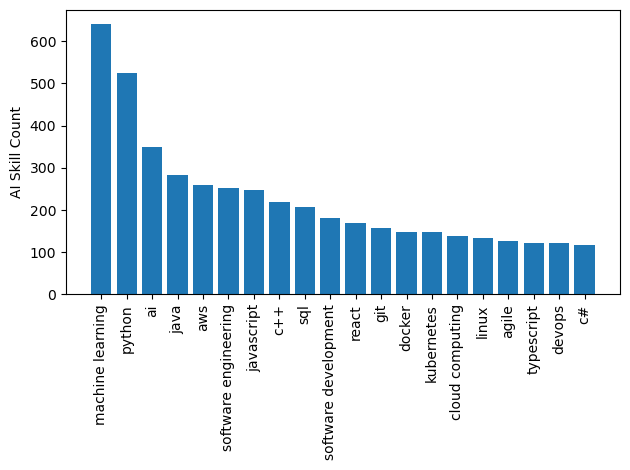

In [13]:
# Plot to visualize the count for "ai_skills"
plt.bar(ai_skills_df['role'], ai_skills_df['skill_count'])
plt.xticks(rotation=90)
plt.ylabel('AI Skill Count')
plt.tight_layout()
plt.show()

In [14]:
# Create a machine learning dataframe comprised of job postings 
# ml_roles df will include all skills also associated with machine learning as a requirement 
# Pass in "ml_roles" into the "count_skills" function to create a series of the Top 50 ml_skills.
term_to_match = ['machine learning']

linkedin_postings_df['job_skills'] = linkedin_postings_df['job_skills']

linkedin_postings_df['has_ml'] = linkedin_postings_df['job_skills'].apply(
    lambda skills: any(term in skills for term in term_to_match)
)
ml_roles = linkedin_postings_df.loc[linkedin_postings_df['has_ml'] == True]

ml_skills = count_skills(ml_roles)
ml_skills

machine learning        642
python                  408
java                    231
aws                     215
ai                      214
software engineering    194
javascript              191
sql                     162
c++                     149
software development    145
cloud computing         127
react                   125
kubernetes              114
docker                  112
agile                   110
git                     104
devops                  101
data science             95
nlp                      90
linux                    90
nosql                    87
typescript               83
c#                       83
azure                    81
data analysis            80
node.js                  72
microservices            71
communication            70
computer science         70
angular                  70
css                      69
html                     67
agile development        65
big data                 65
data analytics           64
leadership          

In [15]:
# Convert the "ml_skills" series into a dataframe of the first 20 skills in preparation for visualization
ml_skills_df = ml_skills.to_frame().reset_index().rename(columns={"index": "role", 0: "skill_count"})
ml_skills_df = ml_skills_df.head(20)
ml_skills_df

,role,skill_count
0,machine learning,642
1,python,408
2,java,231
3,aws,215
4,ai,214
5,software engineering,194
6,javascript,191
7,sql,162
8,c++,149
9,software development,145


In [16]:
# Remove "machine_learning" skill from the dataframe
ml_skills_df = ml_skills_df[1:]
ml_skills_df

,role,skill_count
1,python,408
2,java,231
3,aws,215
4,ai,214
5,software engineering,194
6,javascript,191
7,sql,162
8,c++,149
9,software development,145
10,cloud computing,127


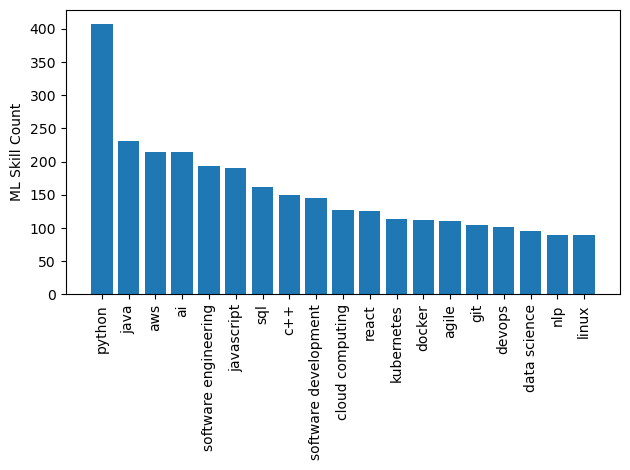

In [17]:
# Plot to visualize the count for "ai_skills"
plt.bar(ml_skills_df['role'], ml_skills_df['skill_count'])
plt.xticks(rotation=90)
plt.ylabel('ML Skill Count')
plt.tight_layout()
plt.show()

Job Skills Summary \ The skills required for AI roles and ML roles are very similar; however the jobs postings with machine learning as a keyword are less than the postings with artificial intelligence which could attributed to the popularity of the term "AI".

Question Seniority/Job level

In [ ]:
# etc 

Question 5 Industry demand 